# I will use the following notebook to demonstrate different steps in preprocessing

## These steps will include:

### 1) Slice timing correction
### 2) Motion correction
### 3) Coregistration
### 4) Spatial and temporal filtering

In [28]:
import os
from glob import glob

# Import new things that we'll need
import pandas as pd
import numpy as np
import nipype.interfaces.afni as afni
import nipype.interfaces.fsl as fsl
from nipype.interfaces.utility import Function
import seaborn as sns
import nibabel as nb
import json
import nipype.interfaces.io as nio
import nipype.pipeline.engine as pe 
import matplotlib.pyplot as plt

%matplotlib inline

### I next want to get a list of all of my functional files

In [24]:
sid = ['021']
base_dir = '/Users/emilymartin/Gitt/mattfeld_2020'
work_dir = '/Users/emilymartin/Gitt'
func_dir = os.path.join(base_dir, f'dset/sub-{sid[0]}/ses-S1/func')
# Get a list of my localizer json and nifti converted files
#loc_func_json = sorted(glob(func_dir + '/*loc*.json'))
#loc_func_files = sorted(glob(func_dir + '/*loc*.nii.gz'))

# Get a list of my study task json and nifti converted files
#study_func_json = sorted(glob(func_dir + '/*study*.json'))
#study_func_files = sorted(glob(func_dir + '/*study*.nii.gz'))

#Get a list of all files in func folder, organized into json or nii.gz
all_func_json = sorted(glob(func_dir + '/*.json'))
all_func_files = sorted(glob(func_dir + '/*.nii.gz'))

### Next I want to build and run function to perform slice timing correction. I'm going to have to extract some important information from the .json files like the multiband slicetiming.

In [25]:
# Here I am building a function that eliminates the
# mapnode directory structure and assists in saving
# all of the outputs into a single directory
def get_subs(func_files):
    '''Produces Name Substitutions for Each Contrast'''
    subs = []
    for curr_run in range(len(func_files)):
        subs.append(('_tshifter%d' %curr_run, ''))
        subs.append(('_volreg%d' %curr_run, ''))
    return subs

# Here I am building a function that takes in a
# text file that includes the number of outliers
# at each volume and then finds which volume (e.g., index)
# has the minimum number of outliers (e.g., min) 
# searching over the first 201 volumes
# If the index function returns a list because there were
# multiple volumes with the same outlier count, pick the first one
def best_vol(outlier_count):
    best_vol_num = outlier_count.index(min(outlier_count[:200]))
    if isinstance(best_vol_num, list):
        best_vol_num = best_vol_num[0]
    return best_vol_num

# Here I am creating a list of lists containing the slice timing for each study run
#slice_timing_list = []
'''
for curr_json in study_func_json:
    curr_json_data = open(curr_json)
    curr_study_func_metadata = json.load(curr_json_data)
    slice_timing_list.append(curr_study_func_metadata['SliceTiming'])
'''
slice_timing_list = []
for curr_json in all_func_json:
    curr_json_data = open(curr_json)
    curr_all_func_metadata = json.load(curr_json_data)
    slice_timing_list.append(curr_all_func_metadata['SliceTiming'])

# Here I am establishing a nipype work flow that I will eventually execute
psb6351_wf = pe.Workflow(name='psb6351_wf')

# Create a Function node to substitute names of files created during pipeline
getsubs = pe.Node(Function(input_names=['func_files'],
                           output_names=['subs'],
                           function=get_subs),
                  name='getsubs')
#getsubs.inputs.func_files = study_func_files
getsubs.inputs.func_files = all_func_files

# Here I am inputing just the first run functional data
# I want to use afni's 3dToutcount to find the number of 
# outliers at each volume.  I will use this information to
# later select the earliest volume with the least number of outliers
# to serve as the base for the motion correction
id_outliers = pe.Node(afni.OutlierCount(),
                      name = 'id_outliers')
#id_outliers.inputs.in_file = study_func_files[0]
id_outliers.inputs.in_file = all_func_files[0]
id_outliers.inputs.automask = True
id_outliers.inputs.out_file = 'outlier_file'


#ATM ONLY: Add an unwarping mapnode here using the field maps


# Create a Function node to identify the best volume based
# on the number of outliers at each volume. I'm searching
# for the index in the first 201 volumes that has the 
# minimum number of outliers and will use the min() function
# I will use the index function to get the best vol. 
getbestvol = pe.Node(Function(input_names=['outlier_count'],
                              output_names=['best_vol_num'],
                              function=best_vol),
                     name='getbestvol')
psb6351_wf.connect(id_outliers, 'out_file', getbestvol, 'outlier_count')

# Extract the earliest volume with the
# the fewest outliers of the first run as the reference 
extractref = pe.Node(fsl.ExtractROI(t_size=1),
                     name = "extractref")
#extractref.inputs.in_file = study_func_files[0]
extractref.inputs.in_file = all_func_files[0]
#extractref.inputs.t_min = int(np.ceil(nb.load(study_func_files[0]).shape[3]/2)) #PICKING MIDDLE
psb6351_wf.connect(getbestvol, 'best_vol_num', extractref, 't_min')

## QUESTION: Would I want to do slice timing correction here?  Why? Why not?
# A: It depends on your data & what you are measuring, but the Poldrack book advises against it
# They recommend doing motion correction first, but you really don't have to.
# I'm not sure if I switched the order correctly, but they look the same, so I think either order is probably fine?

# Below is the command that runs AFNI's 3dTshift command
# this is the node that performs the slice timing correction
# I input the study func files as a list and the slice timing 
# as a list of lists. I'm using a MapNode to iterate over the two.
# this should allow me to parallelize this on the HPC
#tshifter = pe.MapNode(afni.TShift(),
 #                     iterfield=['in_file','slice_timing'],
 #                     name = 'tshifter')
#tshifter.inputs.in_file = study_func_files
#tshifter.inputs.in_file = all_func_files
#tshifter.inputs.tr = str(curr_study_func_metadata['RepetitionTime'])
#tshifter.inputs.tr = str(curr_all_func_metadata['RepetitionTime'])
#tshifter.inputs.slice_timing = slice_timing_list
#tshifter.inputs.outputtype = 'NIFTI_GZ'

# Below is the command that runs AFNI's 3dvolreg command.
# this is the node that performs the motion correction
# I'm iterating over the functional files which I am passing
# functional data from the slice timing correction node before
# I'm using the earliest volume with the least number of outliers
# during the first run as the base file to register to.
volreg = pe.MapNode(afni.Volreg(),
                    iterfield=['in_file'],
                    name = 'volreg')
volreg.inputs.outputtype = 'NIFTI_GZ'
volreg.inputs.zpad = 4
#psb6351_wf.connect(tshifter, 'out_file', volreg, 'in_file')
psb6351_wf.connect(extractref, 'roi_file', volreg, 'basefile')

tshifter = pe.MapNode(afni.TShift(),
                      iterfield=['in_file','slice_timing'],
                      name = 'tshifter')
#tshifter.inputs.in_file = study_func_files
tshifter.inputs.in_file = all_func_files
#tshifter.inputs.tr = str(curr_study_func_metadata['RepetitionTime'])
tshifter.inputs.tr = str(curr_all_func_metadata['RepetitionTime'])
tshifter.inputs.slice_timing = slice_timing_list
tshifter.inputs.outputtype = 'NIFTI_GZ'
psb6351_wf.connect(tshifter, 'out_file', volreg, 'in_file')

# Below is the code if I wanted to use the FSL McFlirt command
'''
motion_corr = pe.MapNode(fsl.MCFLIRT(),
                         iterfield=['in_file'],
                         name = 'motion_corr')
motion_corr.inputs.output_type = 'NIFTI_GZ'
psb6351_wf.connect(tshifter, 'out_file', motion_corr, 'in_file')
psb6351_wf.connect(extractref, 'roi_file', motion_corr, 'ref_file')
'''

# Below is the node that collects all the data and saves
# the outputs that I am interested in. Here in this node
# I use the substitutions input combined with the earlier
# function to get rid of nesting
datasink = pe.Node(nio.DataSink(), name="datasink")
datasink.inputs.base_directory = os.path.join(base_dir, 'derivatives')
datasink.inputs.container = f'sub-{sid[0]}'
#psb6351_wf.connect(tshifter, 'out_file', datasink, 'sltime_corr')
#psb6351_wf.connect(extractref, 'roi_file', datasink, 'study_ref')
psb6351_wf.connect(extractref, 'roi_file', datasink, 'func_ref')
psb6351_wf.connect(volreg, 'out_file', datasink, 'motion.@corrfile')
psb6351_wf.connect(volreg, 'oned_matrix_save', datasink, 'motion.@matrix')
psb6351_wf.connect(volreg, 'oned_file', datasink, 'motion.@par')
psb6351_wf.connect(getsubs, 'subs', datasink, 'substitutions')
psb6351_wf.connect(tshifter, 'out_file', datasink, 'sltime_corr')

# The following two lines set a work directory outside of my 
# local git repo and runs the workflow
psb6351_wf.base_dir = work_dir + f'/psb6351workdir/sub-{sid[0]}'
psb6351_wf.run()


201001-21:59:50,431 nipype.workflow INFO:
	 Workflow psb6351_wf settings: ['check', 'execution', 'logging', 'monitoring']
201001-21:59:50,492 nipype.workflow INFO:
	 Running serially.
201001-21:59:50,495 nipype.workflow INFO:
	 [Node] Setting-up "psb6351_wf.getsubs" in "/Users/emilymartin/Gitt/psb6351workdir/sub-021/psb6351_wf/getsubs".
201001-21:59:50,508 nipype.workflow INFO:
	 [Node] Running "getsubs" ("nipype.interfaces.utility.wrappers.Function")
201001-21:59:50,523 nipype.workflow INFO:
	 [Node] Finished "psb6351_wf.getsubs".
201001-21:59:50,526 nipype.workflow INFO:
	 [Node] Setting-up "psb6351_wf.tshifter" in "/Users/emilymartin/Gitt/psb6351workdir/sub-021/psb6351_wf/tshifter".
201001-21:59:50,568 nipype.workflow INFO:
	 [Node] Setting-up "_tshifter0" in "/Users/emilymartin/Gitt/psb6351workdir/sub-021/psb6351_wf/tshifter/mapflow/_tshifter0".
201001-21:59:50,577 nipype.workflow INFO:
	 [Node] Running "_tshifter0" ("nipype.interfaces.afni.preprocess.TShift"), a CommandLine Interf

201001-22:04:10,484 nipype.interface INFO:
	 stderr 2020-10-01T22:04:10.470849:  on this and  other oblique datasets in the same session.
201001-22:04:10,490 nipype.interface INFO:
	 stderr 2020-10-01T22:04:10.470849: See 3dWarp -help for details.
201001-22:04:10,492 nipype.interface INFO:
	 stderr 2020-10-01T22:04:10.470849:++ Oblique dataset:/Users/emilymartin/Gitt/psb6351workdir/sub-021/psb6351_wf/tshifter/mapflow/_tshifter3/sub-021_ses-S1_task-study_run-2_bold.nii.gz is 30.000002 degrees from plumb.
201001-22:05:40,842 nipype.workflow INFO:
	 [Node] Finished "_tshifter3".
201001-22:05:40,849 nipype.workflow INFO:
	 [Node] Setting-up "_tshifter4" in "/Users/emilymartin/Gitt/psb6351workdir/sub-021/psb6351_wf/tshifter/mapflow/_tshifter4".
201001-22:05:40,863 nipype.workflow INFO:
	 [Node] Running "_tshifter4" ("nipype.interfaces.afni.preprocess.TShift"), a CommandLine Interface with command:
3dTshift -prefix sub-021_ses-S1_task-study_run-3_bold_tshift.nii.gz -tpattern @slice_timing.1D

201001-22:09:06,11 nipype.interface INFO:
	 stderr 2020-10-01T22:09:06.004577:  on this and  other oblique datasets in the same session.
201001-22:09:06,14 nipype.interface INFO:
	 stderr 2020-10-01T22:09:06.004577: See 3dWarp -help for details.
201001-22:09:06,16 nipype.interface INFO:
	 stderr 2020-10-01T22:09:06.004577:++ Oblique dataset:/Users/emilymartin/Gitt/psb6351workdir/sub-021/psb6351_wf/extractref/sub-021_ses-S1_task-loc_run-1_bold_roi.nii.gz is 30.000002 degrees from plumb.
201001-22:09:06,36 nipype.interface INFO:
	 stderr 2020-10-01T22:09:06.036914:++ Oblique dataset:/Users/emilymartin/Gitt/psb6351workdir/sub-021/psb6351_wf/volreg/mapflow/_volreg0/sub-021_ses-S1_task-loc_run-1_bold_tshift.nii.gz is 30.000002 degrees from plumb.
201001-22:10:20,82 nipype.interface INFO:
	 stderr 2020-10-01T22:10:20.082215:++ Max displacement in automask = 2.77 (mm) at sub-brick 297
201001-22:10:20,87 nipype.interface INFO:
	 stderr 2020-10-01T22:10:20.082215:++ Max delta displ  in automask

201001-22:17:56,738 nipype.interface INFO:
	 stderr 2020-10-01T22:17:56.733123:  or viewing/combining it with volumes of differing obliquity,
201001-22:17:56,740 nipype.interface INFO:
	 stderr 2020-10-01T22:17:56.733123:  you should consider running: 
201001-22:17:56,742 nipype.interface INFO:
	 stderr 2020-10-01T22:17:56.733123:     3dWarp -deoblique 
201001-22:17:56,743 nipype.interface INFO:
	 stderr 2020-10-01T22:17:56.733123:  on this and  other oblique datasets in the same session.
201001-22:17:56,745 nipype.interface INFO:
	 stderr 2020-10-01T22:17:56.733123: See 3dWarp -help for details.
201001-22:17:56,751 nipype.interface INFO:
	 stderr 2020-10-01T22:17:56.733123:++ Oblique dataset:/Users/emilymartin/Gitt/psb6351workdir/sub-021/psb6351_wf/extractref/sub-021_ses-S1_task-loc_run-1_bold_roi.nii.gz is 30.000002 degrees from plumb.
201001-22:17:56,769 nipype.interface INFO:
	 stderr 2020-10-01T22:17:56.768966:++ Oblique dataset:/Users/emilymartin/Gitt/psb6351workdir/sub-021/psb63

201001-22:28:32,493 nipype.interface INFO:
	 sub: /Users/emilymartin/Gitt/mattfeld_2020/derivatives/sub-021/motion/_volreg2/sub-021_ses-S1_task-study_run-1_bold_tshift_volreg.nii.gz -> /Users/emilymartin/Gitt/mattfeld_2020/derivatives/sub-021/motion//sub-021_ses-S1_task-study_run-1_bold_tshift_volreg.nii.gz
201001-22:28:34,987 nipype.interface INFO:
	 sub: /Users/emilymartin/Gitt/mattfeld_2020/derivatives/sub-021/motion/_volreg3/sub-021_ses-S1_task-study_run-2_bold_tshift_volreg.nii.gz -> /Users/emilymartin/Gitt/mattfeld_2020/derivatives/sub-021/motion//sub-021_ses-S1_task-study_run-2_bold_tshift_volreg.nii.gz
201001-22:28:37,545 nipype.interface INFO:
	 sub: /Users/emilymartin/Gitt/mattfeld_2020/derivatives/sub-021/motion/_volreg4/sub-021_ses-S1_task-study_run-3_bold_tshift_volreg.nii.gz -> /Users/emilymartin/Gitt/mattfeld_2020/derivatives/sub-021/motion//sub-021_ses-S1_task-study_run-3_bold_tshift_volreg.nii.gz
201001-22:28:40,193 nipype.interface INFO:
	 sub: /Users/emilymartin/Gitt

### Now I will load and plot the motion files

<ipython-input-31-73d72092f584>:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


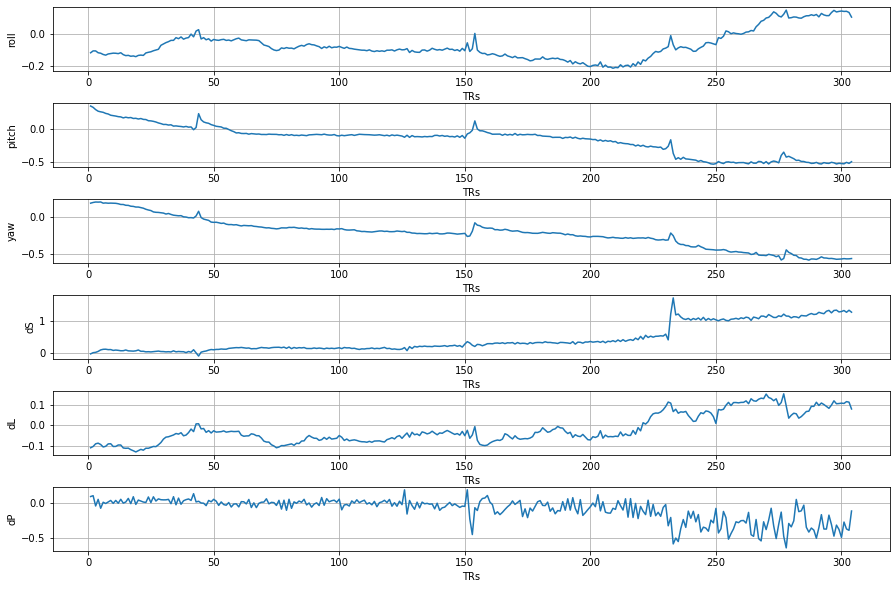

<ipython-input-31-73d72092f584>:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


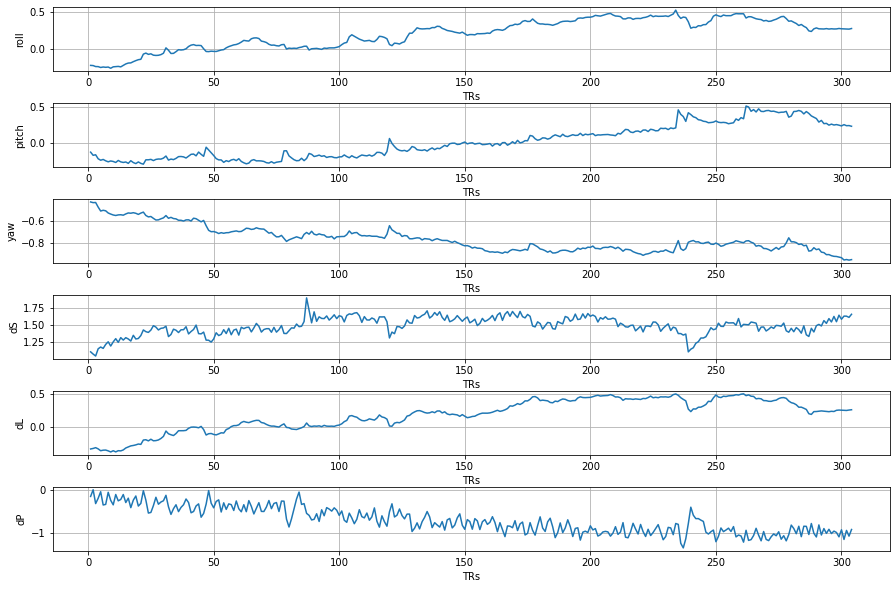

<ipython-input-31-73d72092f584>:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


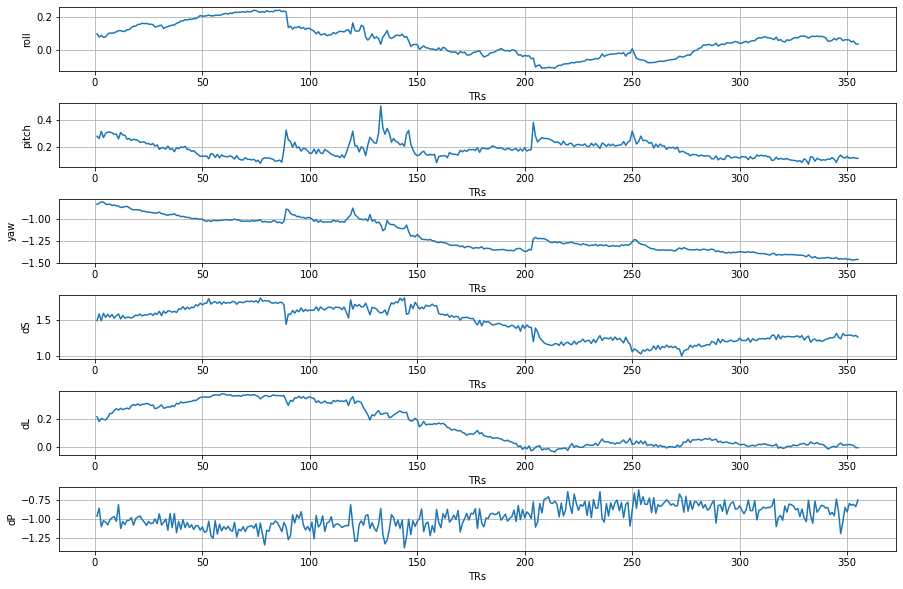

<ipython-input-31-73d72092f584>:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


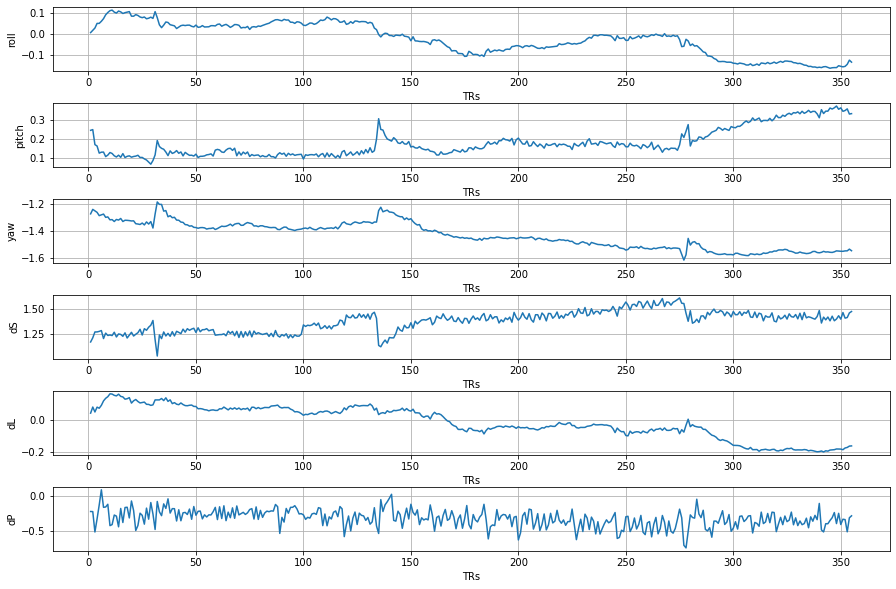

<ipython-input-31-73d72092f584>:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


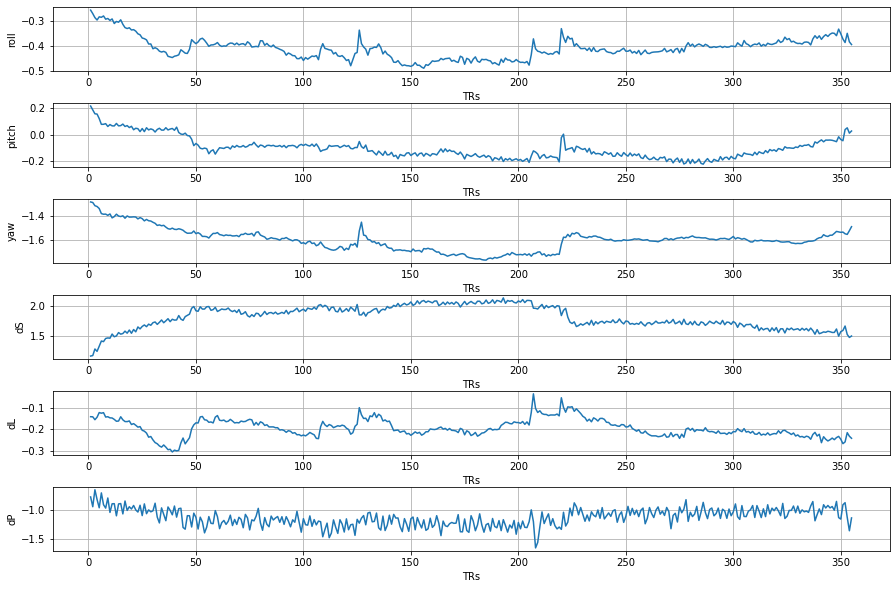

<ipython-input-31-73d72092f584>:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


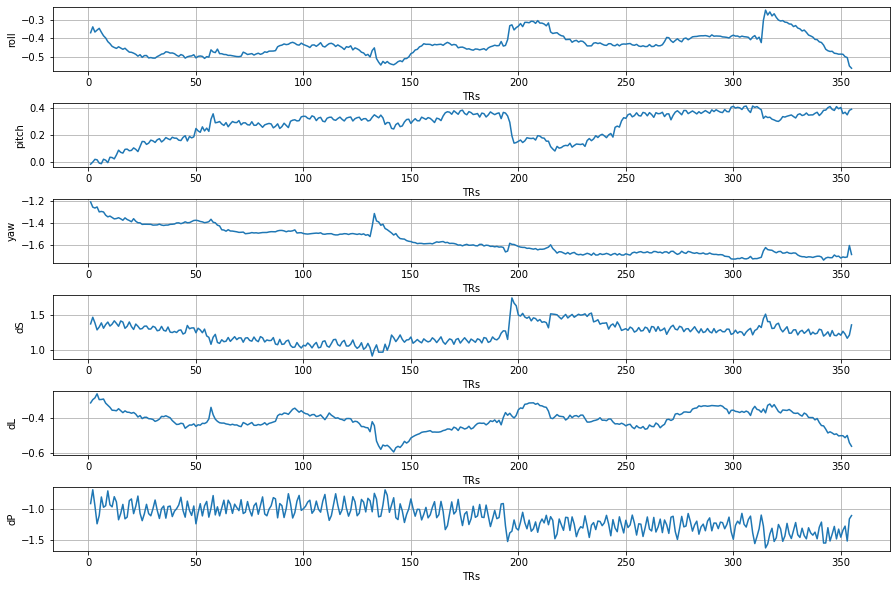

In [31]:
motion_dir = os.path.join(base_dir, f'derivatives/sub-{sid[0]}/motion')
#study_motion_files = sorted(glob(motion_dir + '/*study*_tshift.1D'))
all_motion_files = sorted(glob(motion_dir + '/*_tshift.1D'))

#for curr_mot_file in study_motion_files:
#    motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)
#    motion_df.columns = ['roll', 'pitch', 'yaw', 'dS', 'dL', 'dP']
for curr_mot_file in all_motion_files:
    motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)
    motion_df.columns = ['roll', 'pitch', 'yaw', 'dS', 'dL', 'dP']


    num_vols = range(1, len(motion_df)+1)
    fig, axs = plt.subplots(motion_df.shape[1], 1, figsize = (15, 10))
    # make a little extra space between the subplots
    fig.subplots_adjust(hspace=0.5)

    for idx, curr_col in enumerate(motion_df.keys()):
        axs[idx].plot(num_vols, motion_df[f'{curr_col}'])
        axs[idx].set_xlabel('TRs')
        axs[idx].set_ylabel(f'{curr_col}')
        axs[idx].grid(True)

    plt.show()

[]

In [27]:
#study_motcorr_files = sorted(glob(motion_dir + '/*.nii.gz'))
#study_motcorr_img_data = nb.load(study_motcorr_files[0]).get_fdata()
#study_orig_img_data = nb.load(study_func_files[0]).get_fdata()

all_motcorr_files = sorted(glob(motion_dir + '/*.nii.gz'))
all_motcorr_img_data = nb.load(all_motcorr_files[0]).get_fdata()
all_orig_img_data = nb.load(all_func_files[0]).get_fdata()

#study_motcorr_img_data.shape
all_motcorr_img_data.shape

#print(study_motcorr_img_data[50,50,32,50])
#print(study_orig_img_data[50,50,32,50])
print(all_motcorr_img_data[50,50,32,50])
print(all_orig_img_data[50,50,32,50])

133.0
135.0


In [ ]:
#motion corrected image data = 133
#original image data = 135